# Libraries

In [11]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from torchvision import datasets
import cv2

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

In [13]:
torch.manual_seed(99)

##قسمت آ

In [14]:
def generate_mask(N):
    masks=[]
    batch_size = N
    for j in range(batch_size):
        mask = np.random.choice([0, 1], size=(1,28,28), p=[0.5, 0.5])
        for _ in range(20):
            mask = cv2.filter2D(mask.astype(float), ddepth = -1, kernel = np.array([[1/4, 1/2, 1/4]]))
        mask = (mask > 0.5).astype(float)
        masks.append(mask)
    return torch.tensor(np.array(masks), device = device, dtype = dtype)

##قسمت ب

In [15]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=10000)
train_acc_dataloader = DataLoader(training_data, batch_size=50000)

##قسمت ج

شبکه ی FF

In [16]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=device, dtype=dtype):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.029)
        self.threshold = 2


    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(x_direction @ self.weight.T + self.bias.unsqueeze(0))

    def train(self, x_pos,x_neg):
        g_pos = torch.mean(self.forward(x_pos)**2, dim = 1) # Calculating goodness
        g_neg = torch.mean(self.forward(x_neg)**2, dim = 1) # Calculating goodness
        loss = torch.mean(torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))))
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

شبکه یادگیری

In [17]:
class LearningNet(nn.Module):
    def __init__(self):
        super().__init__()
        dims = [784,600, 580]
        self.layers = []
        self.l1 = Layer(dims[0], dims[1]).to(device)


    def predict(self,x):
        layers_output = torch.Tensor([]).to(device)
        data = x.clone()
        out1 = self.l1(data)
        layers_output = torch.cat([layers_output,out1],1)
        return layers_output


    def perform(self, x_pos, x_neg):
        data_pos1, data_neg1 = self.l1.train(x_pos, x_neg)

FFآموزش شبکه
 به کمک شبکه یادگیری

In [18]:
model = LearningNet()
epochs = 20
for e in range(epochs):
    for t, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)
        x = x/x.max()
        x_pos = torch.flatten(x.clone(), start_dim=1)
        rnd1 = torch.randperm(x.shape[0])
        rnd2 = torch.randperm(x.shape[0])
        masks = generate_mask(x.shape[0])
        neg = masks * x[rnd1] + (1-masks) * x[rnd2]
        x_neg = torch.flatten(neg, start_dim=1)
        model.perform(x_pos.to(device), x_neg.to(device))

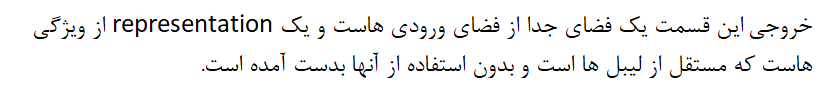

##قسمت د

In [19]:
class LinearClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(600, 10).to(device)
        self.optimizer = Adam(self.parameters(), lr=0.03)
        self.criterion = nn.CrossEntropyLoss()
        self.softmax = nn.Softmax()

    def forward(self,x):
        return self.linear(x)

    def label_to_oh(self, y):
        y = y.cpu().numpy().reshape(-1,1)
        ohe = OneHotEncoder().fit(np.arange(10).reshape((10,1)))
        ohe_y = ohe.transform(y).toarray()
        return torch.Tensor(ohe_y)


    def train(self, x, y):
        x = x.to(device)
        y_r = self.label_to_oh(y).to(device)
        h_activity = model.predict(x)
        y_h = self.forward(h_activity)
        loss = self.criterion(y_h,y_r)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, x, y):
        correct_predictions = 0
        total_samples = 0
        x = x.to(device)
        y_r = self.label_to_oh(y).to(device)
        h_activity = model.predict(x)
        y_h = self.softmax(self.forward(h_activity))
        predicted_labels = torch.argmax(y_h, dim=1)
        true_labels = torch.argmax(y_r, dim=1)
        correct_predictions += (predicted_labels == true_labels).sum().item()
        total_samples += len(y)
        accuracy = correct_predictions / total_samples
        return accuracy

آموزش طبقه بند خطی

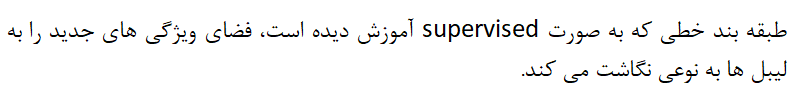

In [20]:
classification_epochs = 25
linear_model = LinearClassification()
for e in range(classification_epochs):
    for t, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)
        x_pos = torch.flatten(x, start_dim=1)
        linear_model.train(x_pos, y)

x_train_acc, y_train_acc = next(iter(train_acc_dataloader))
tttt = torch.flatten(x_train_acc.clone(), start_dim=1)
train_acc = linear_model.predict(tttt, y_train_acc)
print(f'Train Accuracy: ',train_acc)
print(f'Train Error: ', 1-train_acc)

x_test_acc, y_test_acc = next(iter(test_dataloader))
test = torch.flatten(x_test_acc.clone(), start_dim=1)
test_acc = linear_model.predict(test, y_test_acc)
print('---------------------------')
print(f'Test Accuracy: ',test_acc)
print(f'Test Error: ', 1-test_acc)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Accuracy:  0.9668
Train Error:  0.03320000000000001
---------------------------
Test Accuracy:  0.9534
Test Error:  0.046599999999999975


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


##قسمت ه

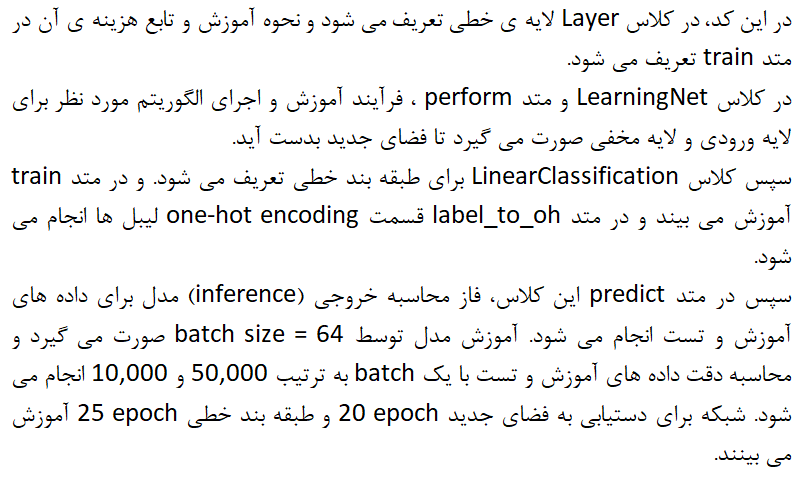

در این تمرین از ویدیوی زیر الهام گرفته شده است.

https://www.youtube.com/watch?v=kvdOow3__CI